# 252 Project Part B

### Imports

In [40]:
from scipy import signal, fftpack # signal to resample signals signal, fftpack to perform fft (TODO: REMOVE IF NOT NEEDED)
from scipy.io import wavfile # to import / export wave files
import numpy as np # to manipulate arrays
import matplotlib.pyplot as plt # to plot functions

### Plotting Functions

In [41]:
# Function to set up time stamps for plotting a wave
def create_timestamps(data_array, fs):
    N = len(data_array) # number of samples in data array
    T_START = 0 # start at time 0
    T_END = N / fs # end at total seconds = total samples / (samples / second)
    time = np.linspace(T_START, T_END, N) # create array of time stamps for each sample between start and end time
    return time

### Wave File Functions

In [31]:
# Function to convert a data array of amplitudes into a wave file with a given max amplitude (max volume) and filename
def output_signal_as_wav(filename, data_array, fs, max_signal_amp):
    signal = max_signal_amp * data_array / np.max(data_array) # set maximum amplitude of signal to max_signal_amp
    int_signal = np.asarray(signal, dtype=np.int16) # convert signal array to array of 16-bit integers
    wavfile.write(f'output/{filename}.wav', fs, int_signal) # write int signal to wavefile with given filename

### Signal Processing Functions

In [42]:
def fft(data_array, fs):  # run fft
    N = len(data_array)
    sig_fft = fftpack.fft(data_array)
    sig_amp = 2 / N * np.abs(sig_fft)
    sig_freq = np.abs(fftpack.fftfreq(N, 1 / fs))
    return sig_freq, sig_amp

chunk time duration (ms):  10.75
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


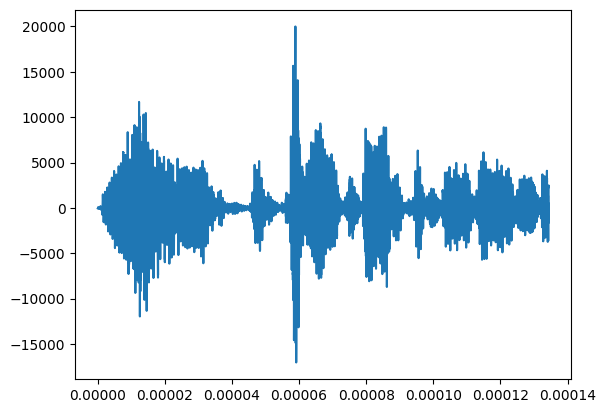

In [28]:
## OLD CODE -- DON'T TOUCH ##

NUM_CHUNKS = 918
CHUNK_TIME_DURATION = (len(data) / FS) / NUM_CHUNKS

print('chunk time duration (ms): ', CHUNK_TIME_DURATION * 1000)

chunk_array = np.split(data, NUM_CHUNKS)

NUM_FREQ_BINS = 300
ORDER = 1
START_FREQ = 1
BW = (FS / 2) / NUM_FREQ_BINS - START_FREQ

THRESHOLD_POWER = 1
output_signal = np.array([])

counter = 1

# TOTAL_OUTPUT_POWER = 0

for chunk in chunk_array:
    if (counter == 200): break
    print(counter)
    counter += 1
    
    RMS_list = []

    for freq_bin in range(0, NUM_FREQ_BINS):
        F_LOW = START_FREQ + freq_bin * BW
        F_HIGH = START_FREQ + BW + freq_bin * BW
        sos_bandpass = signal.butter(ORDER, [F_LOW, F_HIGH], btype='bandpass', fs=FS, output='sos')
        filtered_bin_data = signal.sosfilt(sos_bandpass, chunk)
        RMS_list.append(np.sqrt(np.mean(filtered_bin_data ** 2)))

    RMS_raw = np.array(RMS_list)
    RMS_filtered = []

    NUM_SAMPLES_PER_CHUNK = int(FS*CHUNK_TIME_DURATION)
    current_signal = np.zeros(NUM_SAMPLES_PER_CHUNK)

    for i in range(0,NUM_FREQ_BINS):
        if RMS_raw[i] > THRESHOLD_POWER:
            RMS_filtered.append(RMS_raw[i])
            
            chunk_time_start_output = i * CHUNK_TIME_DURATION
            chunk_time_end_output = chunk_time_start_output + CHUNK_TIME_DURATION
            f_c = START_FREQ + BW/2 + i * BW

            chunk_time = np.linspace(2*np.pi*f_c*chunk_time_start_output, 2*np.pi*f_c*chunk_time_end_output, NUM_SAMPLES_PER_CHUNK)

            current_signal = np.add(current_signal, RMS_raw[i] * np.sin(chunk_time))
        
        else: RMS_filtered.append(0)

    output_signal = np.append(output_signal, current_signal)

output_for_wave = MAX_AMP*output_signal / np.max(output_signal) # new maximum is now 255

x = np.linspace(0, len(output_for_wave) / FS, len(output_for_wave))

plt.plot(x, output_for_wave)
plt.show()

dataout = np.asarray(output_for_wave, dtype=np.int16) # to integer type 16

wavfile.write('robot.wav',FS,dataout)

In [ ]:
################## UNIT TESTING SPACE ##################



### Input

In [46]:
FS, data = wavfile.read('rawaudio2.wav') # load the file + its sampling frequency
data = np.array(data) # convert data to numpy array

### Downsampling

- Limit sampling frequency of signal to 16kHz for performance
- Tradeoff: max signal frequency that can be captured is fs / 2 = **8kHz**
- Tradeoff is acceptable for analyzing voice signal as most intelligible signal is between **2-4KHz** (https://www.dpamicrophones.com/mic-university/facts-about-speech-intelligibility), and energy above **5kHz** has "traditionally been neglected in speech perception research" (https://www.frontiersin.org/articles/10.3389/fpsyg.2014.00587/full)

original # of samples:  128000  @ sampling frequency:  16000
new # of samples:  128000  @ sampling frequency:  16000


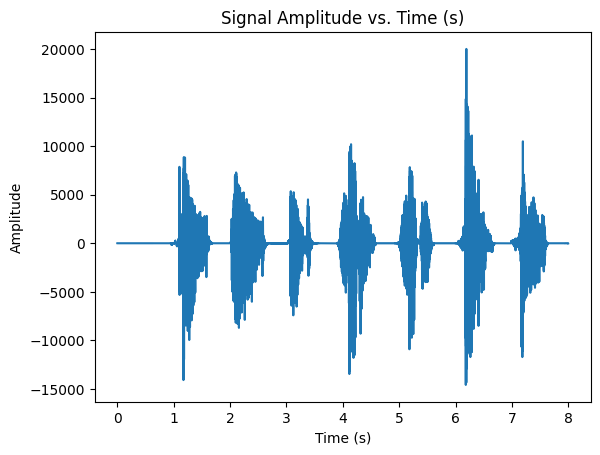

(128000,) 16000 20000


In [48]:
print('original # of samples: ', len(data), ' @ sampling frequency: ', FS)

MAX_FS = 16000 # set max frequency to 16kHz
if FS > MAX_FS: # cap sampling frequency at 16kHz
    NUM_SAMPLES = round(len(data) * float(MAX_FS) / FS) # reduce # of samples by ratio of sampling frequencies
    data = signal.resample(data, NUM_SAMPLES) # resample at reduced sampling frequency
    FS = MAX_FS # set sampling frequency to 16kHz

print('new # of samples: ', len(data), ' @ sampling frequency: ', FS)

# plot downsampled wave
plt.title('Signal Amplitude vs. Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(create_timestamps(data, FS), data)
plt.show()

MAX_AMP = 20000 # set max volume of output wave to be 20log(20000) ≈ 86 dB
output_signal_as_wav('downsampled', data, FS, MAX_AMP)

## Time Chunking

**Design choices to consider**
- number of chunks
- duration of chunks
- gaps / overlap between chunks

**Assumptions**
- let duration of all chunks be the same, and let order of magnitude of duration be from 10^-2 to 10^-3
    - having non-equal duration will make it difficult to tune chunk size to get a desired output because it will add variance and thus randomness
- let parameters be set such that maximal amount of signal is inputted into chunks (i.e. no gaps, use enough chunks to get through majority of signal duration)
    - cutting out signal is hypothesized to reduce intelligibility (analogous to muting an audio file every x milliseconds, thus hypothesized to be unlikely to contribute to robotic effect, but this will be tested for confirmation)

**Test Cases**
- few chunks of longer duration vs. many chunks of short duration
    1. 20ms chunk duration
    2. 10ms chunk duration
    3. 5ms chunk duration
- gap size
    1. no gap
    2. small gap (1/1000th of the duration of a consonant ≈ 200ms (https://wordcounter.net/blog/2016/06/02/101702_how-fast-average-person-speaks.html))
    3. large gap (1/100th of the duration of a consonant)
- overlap
    1. no overlap (same as no gap)
    2. small overlap (1/1000th of the duration of a consonant)
    3. large overlap (1/100th of the duration of a consonant)

chunk time duration (ms):  20.0
samples in each chunk:  320 

gap time duration (ms):  2.0
samples in each gap:  32 

overlap time duration (ms):  0
samples in each overlap:  0 

number of chunks:  363 

last allowable sample index:  127776
minimum leftover samples, should be less than 320:  224 

length of data array:  128000
final data index:  127776
leftover samples, should be less than 320:  224 

shape of chunk array, should be (363, 320):  (363, 320)
sampling frequency (should be 16k):  16000


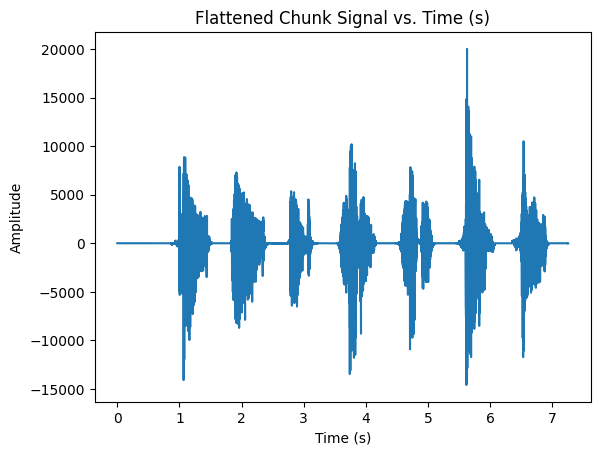

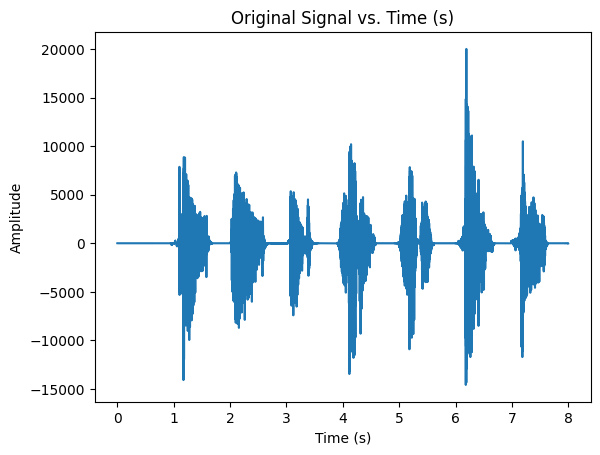

In [45]:
CHUNK_TIME_DURATION = 20 / 1000 # 20 ms
# CHUNK_TIME_DURATION = 10 / 1000 # 10 ms
# CHUNK_TIME_DURATION = 5 / 1000 # 5 ms
NUM_SAMPLES_PER_CHUNK = int(FS * CHUNK_TIME_DURATION) # (samples / second) * (seconds / chunk) = samples / chunk

print('chunk time duration (ms): ', CHUNK_TIME_DURATION * 1000)
print('samples in each chunk: ', NUM_SAMPLES_PER_CHUNK, '\n')

# GAP_TIME_DURATION = 0 # no gap
# GAP_TIME_DURATION = 1/1000 * 200/1000 # 1/1000th of a consonant in seconds
GAP_TIME_DURATION = 1/100 * 200/1000 # 1/100th of a consonant in seconds
# GAP_TIME_DURATION = 1/50 * 200/1000 # 1/100th of a consonant in seconds

OVERLAP_TIME_DURATION = 0 # no overlap
# OVERLAP_TIME_DURATION = 1/1000 * 200/1000 # 1/1000th of a consonant in seconds
# OVERLAP_TIME_DURATION = 1/100 * 200/1000 # 1/10th of a consonant in seconds
# OVERLAP_TIME_DURATION = 1/50 * 200/1000 # 1/10th of a consonant in seconds

NUM_SAMPLES_PER_GAP = int(FS * GAP_TIME_DURATION) # (samples / second) * (seconds / gap) = samples / gap
NUM_SAMPLES_PER_OVERLAP = int(FS * OVERLAP_TIME_DURATION) # (samples / second) * (seconds / overlap) = samples / overlap

print('gap time duration (ms): ', GAP_TIME_DURATION * 1000)
print('samples in each gap: ', NUM_SAMPLES_PER_GAP, '\n')

print('overlap time duration (ms): ', OVERLAP_TIME_DURATION * 1000)
print('samples in each overlap: ', NUM_SAMPLES_PER_OVERLAP, '\n')

NUM_CHUNKS = len(data) // (NUM_SAMPLES_PER_CHUNK + NUM_SAMPLES_PER_GAP - NUM_SAMPLES_PER_OVERLAP) # truncate to prevent indexing beyond available samples in data array
print('number of chunks: ', NUM_CHUNKS, '\n')

LAST_SAMPLE_INDEX = NUM_CHUNKS * (NUM_SAMPLES_PER_CHUNK + NUM_SAMPLES_PER_GAP - NUM_SAMPLES_PER_OVERLAP) # define end condition when iterating over data array by calculating max index that leads to a complete chunk
print('last allowable sample index: ', LAST_SAMPLE_INDEX)
print(f'minimum leftover samples, should be less than {NUM_SAMPLES_PER_CHUNK}: ', len(data) - LAST_SAMPLE_INDEX, '\n') # check that minimum leftover samples don't fit into a full chunk (ensures no chunks are wasted)


chunk_array = np.empty((NUM_CHUNKS, NUM_SAMPLES_PER_CHUNK)) # initialize n x m array, n chunks each containing m samples
chunk_index = 0 # set up index to insert samples into correct chunk (between 0 and NUM_CHUNKS)
data_index = 0 # set up index to find data from original data array (between 0 and LAST_SAMPLE_INDEX)

# loop over data array while there are enough samples left to fill a complete chunk
while data_index < LAST_SAMPLE_INDEX:
    # fill a chunk with NUM_SAMPLES_PER_CHUNK samples
    for i in range(0, NUM_SAMPLES_PER_CHUNK):
        chunk_array[chunk_index, i] = data[data_index + i]
    chunk_index += 1 # increment to next chunk
    data_index += NUM_SAMPLES_PER_CHUNK + NUM_SAMPLES_PER_GAP - NUM_SAMPLES_PER_OVERLAP # increment to next spot to sample data from

print('length of data array: ', len(data))
print('final data index: ', data_index) # confirm that last index taken from data array is smaller than total samples available (avoid sampling data that doens't exist)
print(f'leftover samples, should be less than {NUM_SAMPLES_PER_CHUNK}: ', len(data) - data_index, '\n')

print(f'shape of chunk array, should be ({NUM_CHUNKS}, {NUM_SAMPLES_PER_CHUNK}): ', chunk_array.shape) # final chunk array should have shape as defined earlier

print('sampling frequency (should be 16k): ', FS)
# validate chunking
flattened_chunks = chunk_array.flatten()

plt.figure(0)
plt.title('Flattened Chunk Signal vs. Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(create_timestamps(flattened_chunks, FS), flattened_chunks)
plt.show()

plt.figure(1)
plt.title('Original Signal vs. Time (s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(create_timestamps(data, FS), data)
plt.show()

output_signal_as_wav('chunked', flattened_chunks, FS, 20000)

### Frequency Filtering



chunk time duration (ms):  10.75
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
sample:  (300,)


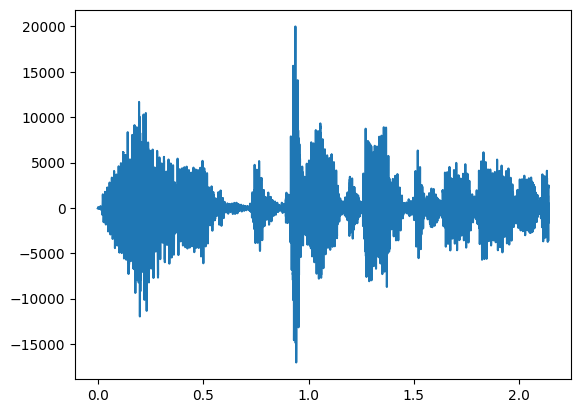

In [11]:
NUM_FREQ_BINS = 300
ORDER = 1
START_FREQ = 1
BW = (FS / 2) / NUM_FREQ_BINS - START_FREQ

THRESHOLD_POWER = 1
output_signal = np.array([])

counter = 1

sample = []

# TOTAL_OUTPUT_POWER = 0

for chunk in chunk_array:
    if (counter == 200): break
    print(counter)
    counter += 1
    
    RMS_list = []

    for freq_bin in range(0, NUM_FREQ_BINS):
        F_LOW = START_FREQ + freq_bin * BW
        F_HIGH = START_FREQ + BW + freq_bin * BW
        sos_bandpass = signal.butter(ORDER, [F_LOW, F_HIGH], btype='bandpass', fs=FS, output='sos')
        filtered_bin_data = signal.sosfilt(sos_bandpass, chunk)
        RMS_list.append(np.sqrt(np.mean(filtered_bin_data ** 2)))

    # TEST CODE TO SEE IF FILTERING BEFORE CHUNKING IS SAME AS AFTER CHUNKING
    if counter == 2:
        sample += RMS_list

    RMS_raw = np.array(RMS_list)
    RMS_filtered = []

    NUM_SAMPLES_PER_CHUNK = int(FS*CHUNK_TIME_DURATION)
    current_signal = np.zeros(NUM_SAMPLES_PER_CHUNK)

    for i in range(0,NUM_FREQ_BINS):
        if RMS_raw[i] > THRESHOLD_POWER:
            RMS_filtered.append(RMS_raw[i])
            
            chunk_time_start_output = i * CHUNK_TIME_DURATION
            chunk_time_end_output = chunk_time_start_output + CHUNK_TIME_DURATION
            f_c = START_FREQ + BW/2 + i * BW

            chunk_time = np.linspace(2*np.pi*f_c*chunk_time_start_output, 2*np.pi*f_c*chunk_time_end_output, NUM_SAMPLES_PER_CHUNK)

            current_signal = np.add(current_signal, RMS_raw[i] * np.sin(chunk_time))
        
        else: RMS_filtered.append(0)

    output_signal = np.append(output_signal, current_signal)

print('sample: ', np.shape(np.array(sample)))

output_for_wave = MAX_AMP*output_signal / np.max(output_signal) # new maximum is now 255

x = np.linspace(0, len(output_for_wave) / FS, len(output_for_wave))

plt.plot(x, output_for_wave)
plt.show()

dataout = np.asarray(output_for_wave, dtype=np.int16) # to integer type 16

wavfile.write('robot.wav',FS,dataout)

In [39]:
input_fs, new_input = wavfile.read('countdown.wav')

new_input_samples = round(len(new_input) * float(16000) / input_fs)
new_input = signal.resample(new_input, new_input_samples)

total_time = 8
total_samples = int(total_time / (1 / 16000)) # total samples = total seconds / (seconds / sample)

new_input = new_input[0: total_samples]

output_signal_as_wav('rawaudio2', new_input, 16000, 20000)